<a href="https://colab.research.google.com/github/mgeraldo/MIT-DataScience-Analytics/blob/main/XGBoost_Assignment_15_1A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import xgboost
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)

## Dataset Import

Using the LendingClub loans dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
url = "drive/MyDrive/Colab Notebooks/loans.csv"
df =  pd.read_csv(url, index_col= False )


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516 entries, 0 to 9515
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   default      9516 non-null   int64  
 1   installment  9516 non-null   int64  
 2   log_income   9516 non-null   float64
 3   fico_score   9516 non-null   int64  
 4   rev_balance  9516 non-null   float64
 5   inquiries    9516 non-null   int64  
 6   records      9516 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 520.5 KB


In [ ]:
df.head(6)

,default,installment,log_income,fico_score,rev_balance,inquiries,records
0,0,829,4.93,737,28.85,0,0
1,0,228,4.81,707,33.62,0,0
2,0,367,4.51,682,3.51,1,0
3,0,162,4.93,712,33.67,1,0
4,0,103,4.91,667,4.74,0,0
5,0,125,5.17,727,50.81,0,0


In [ ]:
df.default.value_counts(normalize=True)

0    0.840164
1    0.159836
Name: default, dtype: float64

## Training and Test Datasets

Let's split the data 70/30 into a training set (which we will use to build models) and a test set (on which we will evaluate any model we build).

In [ ]:

X = df.drop(['default'], axis=1)
y = df['default']


# Encode string class values as integers to avoid errors in newer versions of XGBoost
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
y = label_encoder.transform(y)


# Splitting data into training and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
eval_set=[(X_test, y_test)]
print(X_train.shape, X_test.shape)


(6661, 6) (2855, 6)


In [ ]:
print('Initializing xgboost.sklearn.XGBClassifier and starting training...')

st = datetime.now()

clf = xgboost.sklearn.XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.05,
    seed=9616,
    max_depth=20,
    gamma=10,
    n_estimators=500)

clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=eval_set, verbose=False)

print(datetime.now()-st)

y_pred = clf.predict(X_test)


accuracy = accuracy_score(np.array(y_test).flatten(), y_pred)
print("Accuracy: %.10f%%" % (accuracy * 100.0))

accuracy_per_roc_auc = roc_auc_score(np.array(y_test).flatten(), y_pred)
print("ROC-AUC: %.10f%%" % (accuracy_per_roc_auc * 100))


Initializing xgboost.sklearn.XGBClassifier and starting training...
0:00:01.316050
Accuracy: 83.4325744308%
ROC-AUC: 50.0000000000%


In [ ]:
confusion_matrix(y_test,y_pred)

array([[2382,    0],
       [ 473,    0]])

In [ ]:
y_train_pred = clf.predict(X_train)
auc_train = roc_auc_score(np.array(y_train).flatten(), y_train_pred)
print("ROC-AUC: %.10f%%" % (auc_train * 100))

ROC-AUC: 50.0000000000%


In [ ]:
confusion_matrix(y_train,y_train_pred)

array([[5613,    0],
       [1048,    0]])

## Variable Importance

Feature importance based on weight

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

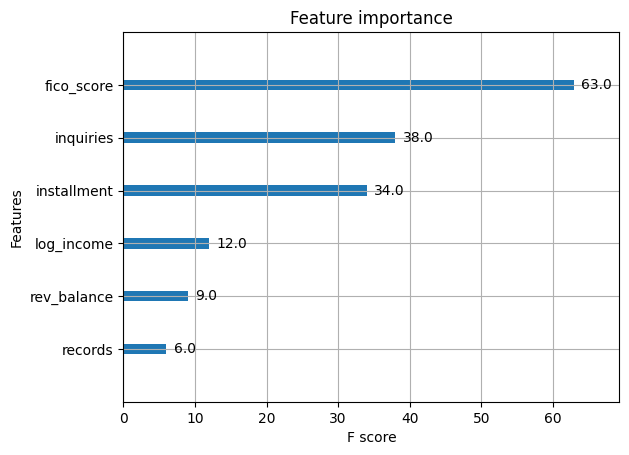

In [ ]:
xgboost.plot_importance(clf)

Feature Importance based on Gain

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

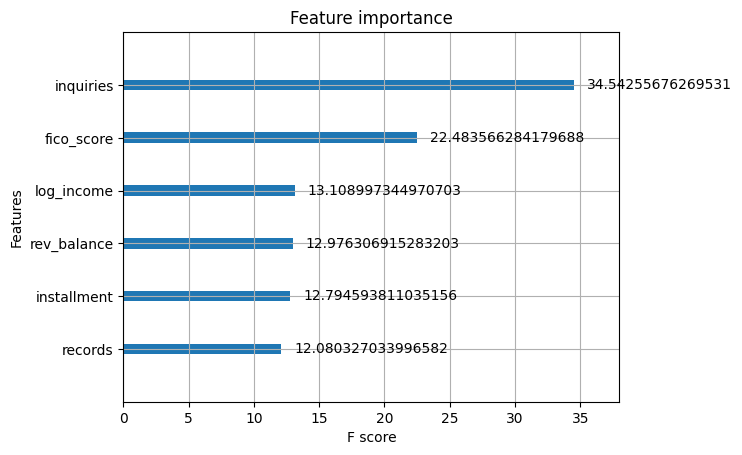

In [ ]:
xgboost.plot_importance(clf, importance_type='gain')

## Hyperparameter Optimization

The AUC of 0.5 is terrible, I will try to improve it by selecting better paramters for learning Rate and Gamma.

In [ ]:
l_rate_vals = [0.05,0.1,0.15,0.2]
gamma_vals = [0,0.1,0.5,1,2,4]

grid = pd.DataFrame(columns = ['Learning Rate', 'Gamma', 'Accuracy','AUC','Train AUC','%pos'])

for l in l_rate_vals:
  for g in gamma_vals:
    clf = xgboost.sklearn.XGBClassifier(
    objective="binary:logistic",
    learning_rate= l,
    seed=9616,
    max_depth=50,
    gamma=g,
    n_estimators=500)
    clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=eval_set, verbose=False)
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    accuracy = accuracy_score(np.array(y_test).flatten(), y_pred)
    auc = roc_auc_score(np.array(y_test).flatten(), y_pred)
    train_auc = roc_auc_score(np.array(y_train).flatten(), y_pred_train)
    row = pd.DataFrame(data = [[l,g,accuracy,auc, train_auc, sum(y_pred)/len(y_pred)]], columns = ['Learning Rate', 'Gamma', 'Accuracy','AUC','Train AUC','%pos'])
    grid = pd.concat([grid,row], ignore_index= True, axis =0)


In [ ]:
grid.sort_values('AUC', ascending = False).head(5)

,Learning Rate,Gamma,Accuracy,AUC,Train AUC,%pos
8,0.10,0.5,0.824518,0.518691,0.853531,0.030123
19,0.20,0.1,0.818914,0.515332,0.941317,0.035727
21,0.20,1,0.825569,0.511696,0.686368,0.022767
20,0.20,0.5,0.823818,0.509799,0.731781,0.023818
13,0.15,0.1,0.830823,0.507220,0.667939,0.011208


In [ ]:
grid[grid['Train AUC'] == grid['Train AUC'].max()]

,Learning Rate,Gamma,Accuracy,AUC,Train AUC,%pos
19,0.2,0.1,0.818914,0.515332,0.941317,0.035727


The improvement made was very small. The high Training AUC indicates that the model is overfitting.
I will try improving max depht and Early Stopping.

In [ ]:
md_vals = [5,10,15,20,25,30]
es_vals = [5,10,15,20,25,30]

grid = pd.DataFrame(columns = ['Max Depth', 'Early Stopping', 'Accuracy','AUC','Train AUC','%pos'])

for md in md_vals:
  for es in es_vals:
    clf = xgboost.sklearn.XGBClassifier(
    objective="binary:logistic",
    learning_rate= 0.1,
    seed=9616,
    max_depth=md,
    gamma=0.5,
    n_estimators=500)
    clf.fit(X_train, y_train, early_stopping_rounds=es, eval_metric="auc", eval_set=eval_set, verbose=False)

    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

    accuracy = accuracy_score(np.array(y_test).flatten(), y_pred)
    auc = roc_auc_score(np.array(y_test).flatten(), y_pred)
    train_auc = roc_auc_score(np.array(y_train).flatten(), y_pred_train)

    row = pd.DataFrame(data = [[md, es ,accuracy,auc, train_auc, sum(y_pred)/len(y_pred)]], columns = ['Max Depth', 'Early Stopping', 'Accuracy','AUC','Train AUC','%pos'])
    grid = pd.concat([grid,row], ignore_index= True, axis =0)

In [ ]:
grid.sort_values('AUC', ascending = False).head(5)

,Max Depth,Early Stopping,Accuracy,AUC,Train AUC,%pos
26,25,15,0.827320,0.520370,0.840649,0.027320
28,25,25,0.827320,0.520370,0.840649,0.027320
27,25,20,0.827320,0.520370,0.840649,0.027320
29,25,30,0.827320,0.520370,0.840649,0.027320
33,30,20,0.823818,0.515729,0.852099,0.028722


Small improvement again.  
I will do regularization now.

In [ ]:
alpha_vals = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
lambda_vals = [0,5,10,20,50,75,100]

grid = pd.DataFrame(columns = ['reg_alpha', 'reg_lambda', 'Accuracy','AUC','Train AUC','%pos'])

for reg_alpha in alpha_vals:
  for reg_lambda in lambda_vals:
    clf = xgboost.sklearn.XGBClassifier(
    objective="binary:logistic",
    learning_rate= 0.1,
    seed=9616,
    max_depth=25,
    gamma=0.5,
    n_estimators=500,
    reg_alpha = reg_alpha,
    reg_lambda= reg_lambda
    )
    clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=eval_set, verbose=False)

    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

    accuracy = accuracy_score(np.array(y_test).flatten(), y_pred)
    auc = roc_auc_score(np.array(y_test).flatten(), y_pred)
    train_auc = roc_auc_score(np.array(y_train).flatten(), y_pred_train)

    row = pd.DataFrame(data = [[reg_alpha, reg_lambda ,accuracy,auc, train_auc, sum(y_pred)/len(y_pred)]], columns = ['reg_alpha', 'reg_lambda', 'Accuracy','AUC','Train AUC','%pos'])
    grid = pd.concat([grid,row], ignore_index= True, axis =0)

In [ ]:
grid.sort_values('AUC', ascending = False).head(5)

,reg_alpha,reg_lambda,Accuracy,AUC,Train AUC,%pos
28,0.2,0,0.822067,0.520610,0.877863,0.035377
21,0.15,0,0.819264,0.517236,0.915076,0.036778
35,0.25,0,0.816112,0.514500,0.894084,0.039229
14,0.1,0,0.817163,0.514283,0.918893,0.037478
42,0.3,0,0.819965,0.514268,0.866412,0.033275


## Grid Search
The improvement is too low, I will do a full grid search to reduce the gap between Training AUC and Testing AUC.

In [ ]:
l_rate_vals = [0.05,0.1,0.15,0.2]
gamma_vals = [0,0.1,0.5,1]
max_depht_vals = [10,15,20]
alpha_vals = [0, 0.15, 0.2, 0.25,0.3]
lambda_vals = [0]

grid = pd.DataFrame(columns = ['Learning Rate', 'Gamma', 'Max Depht', 'Alpha', 'Lambda','Train AUC', 'OOS AUC', 'OOS Accuracy','OOS Precision','OOS Recall'])

for l in l_rate_vals:
  for g in gamma_vals:
    for md in max_depht_vals:
      for reg_alpha in alpha_vals:
        for reg_lambda in lambda_vals:
          clf = xgboost.sklearn.XGBClassifier(
          objective="binary:logistic",
          learning_rate= l,
          seed=9616,
          max_depth=md,
          gamma=g,
          n_estimators=500,
          reg_alpha = reg_alpha,
          reg_lambda = reg_lambda
          )
          clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=eval_set, verbose=False)
          y_pred = clf.predict(X_test)
          y_pred_train = clf.predict(X_train)
          accuracy = accuracy_score(np.array(y_test).flatten(), y_pred)
          auc = roc_auc_score(np.array(y_test).flatten(), y_pred)
          train_auc = roc_auc_score(np.array(y_train).flatten(), y_pred_train)
          conf_matrix = confusion_matrix(y_test, y_pred)
          if (conf_matrix[1,1]+conf_matrix[1,0] == 0):
            recall = 0
          else:
            recall = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0])
          if (conf_matrix[1,1]+conf_matrix[0,1] == 0):
            precision = 0
          else:
            precision = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])

          row = pd.DataFrame(data = [[l,g,md,reg_alpha,reg_lambda,train_auc,auc,accuracy,precision, recall]], columns = ['Learning Rate', 'Gamma', 'Max Depht', 'Alpha', 'Lambda','Train AUC', 'OOS AUC', 'OOS Accuracy','OOS Precision','OOS Recall'])
          grid = pd.concat([grid,row], ignore_index= True, axis =0)


In [ ]:
grid.sort_values('OOS AUC', ascending = False).head(5)

,Learning Rate,Gamma,Max Depht,Alpha,Lambda,Train AUC,OOS AUC,OOS Accuracy,OOS Precision,OOS Recall
203,0.20,0.1,15,0.25,0,0.800573,0.529914,0.824869,0.378378,0.088795
81,0.10,0.1,15,0.15,0,0.882156,0.526750,0.822417,0.350877,0.084567
147,0.15,0.1,20,0.2,0,0.896947,0.525468,0.824518,0.362745,0.078224
130,0.15,0,20,0,0,0.966603,0.525078,0.818214,0.320312,0.086681
232,0.20,1,15,0.2,0,0.729784,0.524808,0.829072,0.407407,0.069767


In [ ]:
grid.describe()

,Learning Rate,Train AUC,OOS AUC,OOS Accuracy,OOS Precision,OOS Recall
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,0.125000,0.712158,0.512680,0.825762,0.312824,0.044450
std,0.056019,0.124891,0.006349,0.005804,0.091631,0.022284
min,0.050000,0.500000,0.498328,0.809457,0.000000,0.000000
25%,0.087500,0.619380,0.509312,0.821366,0.288071,0.033827
50%,0.125000,0.696282,0.513188,0.825919,0.314286,0.046512
75%,0.162500,0.814528,0.516657,0.830823,0.357857,0.061311
max,0.200000,0.996660,0.529914,0.834676,0.538462,0.088795


In [ ]:
optimum = grid.sort_values('OOS AUC', ascending = False).head(1)

In [ ]:
 clf = xgboost.sklearn.XGBClassifier(
            objective="binary:logistic",
            learning_rate= optimum['Learning Rate'].values[0],
            seed=9616,
            max_depth=optimum['Max Depht'].values[0],
            gamma=optimum['Gamma'].values[0],
            n_estimators=500,
            reg_alpha = optimum['Alpha'].values[0],
            reg_lambda = optimum['Lambda'].values[0]
            )
clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=eval_set, verbose=False)
y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

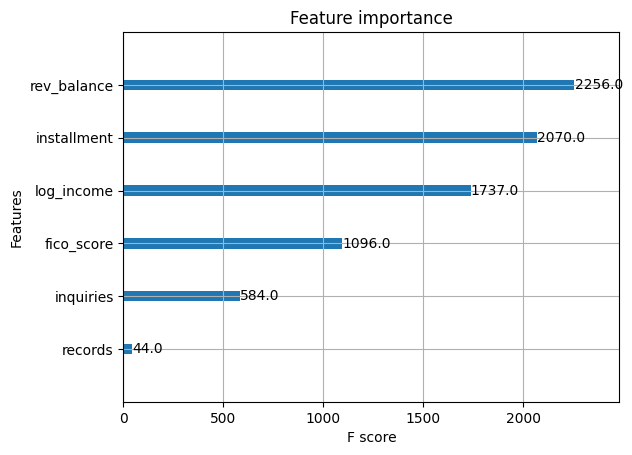

In [ ]:
xgboost.plot_importance(clf, importance_type='weight')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

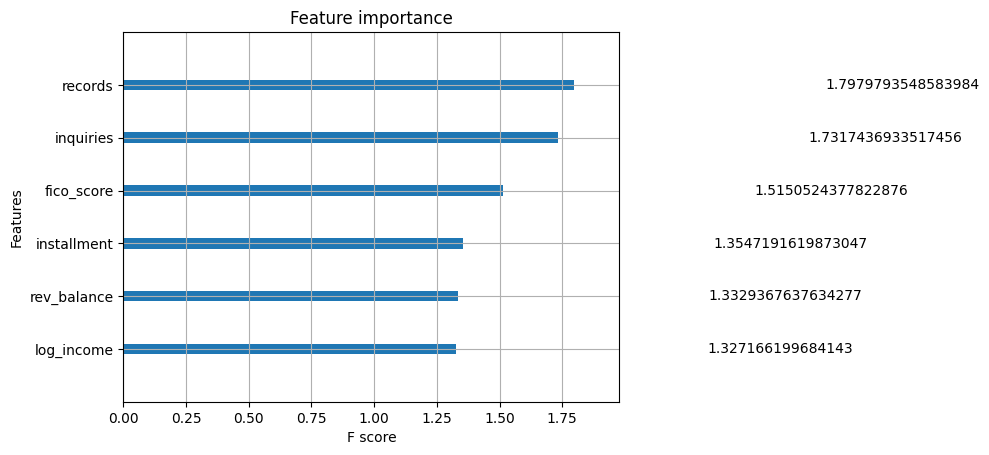

In [ ]:
xgboost.plot_importance(clf, importance_type='gain')

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

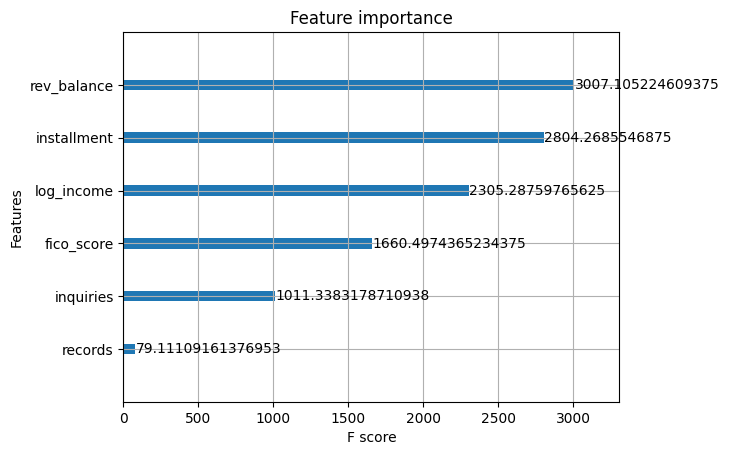

In [ ]:
xgboost.plot_importance(clf, importance_type='total_gain')

In [ ]:
grid[(grid['Max Depht']==15) & (grid['Gamma']==0.1)].sort_values(['Learning Rate','Alpha'],ascending=False)

,Learning Rate,Gamma,Max Depht,Alpha,Lambda,Train AUC,OOS AUC,OOS Accuracy,OOS Precision,OOS Recall
204,0.20,0.1,15,0.3,0,0.718511,0.509589,0.823468,0.275362,0.040169
203,0.20,0.1,15,0.25,0,0.800573,0.529914,0.824869,0.378378,0.088795
202,0.20,0.1,15,0.2,0,0.802481,0.519980,0.821016,0.317308,0.069767
201,0.20,0.1,15,0.15,0,0.888836,0.518968,0.812259,0.273381,0.080338
200,0.20,0.1,15,0,0,0.779580,0.512566,0.821366,0.282353,0.050740
144,0.15,0.1,15,0.3,0,0.674618,0.508090,0.826620,0.288462,0.031712
143,0.15,0.1,15,0.25,0,0.792462,0.520400,0.821716,0.323529,0.069767
142,0.15,0.1,15,0.2,0,0.802481,0.516179,0.818914,0.288462,0.063425
141,0.15,0.1,15,0.15,0,0.889790,0.521682,0.819615,0.315789,0.076110
140,0.15,0.1,15,0,0,0.856393,0.520618,0.820665,0.317757,0.071882


In [ ]:
l_rate_vals = [0.3,0.35,0.4]
gamma_vals = [0.1]
max_depht_vals = [11,12,13,14]
alpha_vals = [0.2,0.225, 0.25, 0.275,0.3]
lambda_vals = [0]

grid = pd.DataFrame(columns = ['Learning Rate', 'Gamma', 'Max Depht', 'Alpha', 'Lambda','Train AUC', 'OOS AUC', 'OOS Accuracy','OOS Precision','OOS Recall'])

for l in l_rate_vals:
  for g in gamma_vals:
    for md in max_depht_vals:
      for reg_alpha in alpha_vals:
        for reg_lambda in lambda_vals:
          clf = xgboost.sklearn.XGBClassifier(
          objective="binary:logistic",
          learning_rate= l,
          seed=9616,
          max_depth=md,
          gamma=g,
          n_estimators=500,
          reg_alpha = reg_alpha,
          reg_lambda = reg_lambda
          )
          clf.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=eval_set, verbose=False)
          y_pred = clf.predict(X_test)
          y_pred_train = clf.predict(X_train)
          accuracy = accuracy_score(np.array(y_test).flatten(), y_pred)
          auc = roc_auc_score(np.array(y_test).flatten(), y_pred)
          train_auc = roc_auc_score(np.array(y_train).flatten(), y_pred_train)
          conf_matrix = confusion_matrix(y_test, y_pred)
          if (conf_matrix[1,1]+conf_matrix[1,0] == 0):
            recall = 0
          else:
            recall = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0])
          if (conf_matrix[1,1]+conf_matrix[0,1] == 0):
            precision = 0
          else:
            precision = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])

          row = pd.DataFrame(data = [[l,g,md,reg_alpha,reg_lambda,train_auc,auc,accuracy,precision, recall]], columns = ['Learning Rate', 'Gamma', 'Max Depht', 'Alpha', 'Lambda','Train AUC', 'OOS AUC', 'OOS Accuracy','OOS Precision','OOS Recall'])
          grid = pd.concat([grid,row], ignore_index= True, axis =0)

In [ ]:
grid.sort_values('OOS AUC', ascending = False).head(5)

,Learning Rate,Gamma,Max Depht,Alpha,Lambda,Train AUC,OOS AUC,OOS Accuracy,OOS Precision,OOS Recall
13,0.30,0.1,13,0.275,0,0.808206,0.530559,0.823117,0.366667,0.093023
30,0.35,0.1,13,0.200,0,0.849058,0.527433,0.813660,0.307190,0.099366
26,0.35,0.1,12,0.225,0,0.772335,0.527170,0.823117,0.357143,0.084567
56,0.40,0.1,14,0.225,0,0.747468,0.526345,0.818914,0.328125,0.088795
10,0.30,0.1,13,0.200,0,0.830153,0.526135,0.818564,0.325581,0.088795


## Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
model = xgboost.sklearn.XGBClassifier(random_state=42)
param_grid = {
    'learning_rate': np.linspace(0.001, 1.0, 50),
    'max_depth': range(1,21),
    'gamma': np.linspace(0.001, 1.0, 50),
    'n_estimators': range(10,700,10),
    'reg_alpha': np.linspace(0.001,.8,20)
    }

In [ ]:
rcv = RandomizedSearchCV(model,
                        param_distributions = param_grid,
                        cv=5,
                        n_iter=100,
                        scoring='neg_mean_absolute_error',
                        random_state=42)
rcv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
       0.91844898, 0.93883673, 0.95922449, 0.97961224, 1.        ]),
                                        'max_depth': range(1, 21),
                                        'n_estimators': range(10, 700, 10),
                                        'reg_alpha': array([0.001     , 0.04305263, 0.08510526, 0.12715789, 0.16921053,
       0.21126316, 0.25331579, 0.29536842, 0.33742105, 0.37947368,
       0.42152632, 0.46357895, 0.50563158, 0.54768421, 0.58973684,
       0.63178947, 0.67384211, 0.71589474, 0.75794737, 0.8       ])},
                   random_state=42, scoring='neg_mean_absolute_error')

In [ ]:
rcv.best_params_

{'reg_alpha': 0.4635789473684211,
 'n_estimators': 60,
 'max_depth': 8,
 'learning_rate': 0.10293877551020408,
 'gamma': 0.551469387755102}

In [ ]:
y_pred = rcv.best_estimator_.predict(X_test)
y_pred_train = rcv.best_estimator_.predict(X_train)

In [ ]:
grid = pd.DataFrame(columns = ['Learning Rate', 'Gamma', 'Max Depht', 'Alpha', 'Lambda','Train AUC', 'OOS AUC', 'OOS Accuracy','OOS Precision','OOS Recall'])

accuracy = accuracy_score(np.array(y_test).flatten(), y_pred)
auc = roc_auc_score(np.array(y_test).flatten(), y_pred)
train_auc = roc_auc_score(np.array(y_train).flatten(), y_pred_train)
conf_matrix = confusion_matrix(y_test, y_pred)
if (conf_matrix[1,1]+conf_matrix[1,0] == 0):
  recall = 0
else:
  recall = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0])
if (conf_matrix[1,1]+conf_matrix[0,1] == 0):
  precision = 0
else:
  precision = conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])

row = pd.DataFrame(data = [[l,g,md,reg_alpha,reg_lambda,train_auc,auc,accuracy,precision, recall]], columns = ['Learning Rate', 'Gamma', 'Max Depht', 'Alpha', 'Lambda','Train AUC', 'OOS AUC', 'OOS Accuracy','OOS Precision','OOS Recall'])
grid = pd.concat([grid,row], ignore_index= True, axis =0)

grid.sort_values('OOS AUC', ascending = False).head(5)

,Learning Rate,Gamma,Max Depht,Alpha,Lambda,Train AUC,OOS AUC,OOS Accuracy,OOS Precision,OOS Recall
0,0.2,4,14,0.3,0,0.594466,0.507647,0.830123,0.333333,0.02537
